<a href="https://colab.research.google.com/github/fds-imane/Data_Marketing/blob/main/data_marketing_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Lumina & CO

### TP 2 ETAPE I - Hajar

In [61]:
import pandas as pd

# Charger les fichiers CSV
customers = pd.read_csv('customers.csv')
transactions = pd.read_csv('transactions.csv')
campaigns = pd.read_csv('campaigns.csv')

print("Les 3 fichiers sont chargés avec succès.")

Les 3 fichiers sont chargés avec succès.


### Snapshot date

In [62]:

transactions['invoice_date'] = pd.to_datetime(transactions['invoice_date'])

print("✅ Conversion des dates réussie !")

# 1. On "coupe" les données et on crée une copie indépendante
transactions_clean = transactions.dropna(subset=['customer_id']).copy()

# 2. On définit la date de référence (le snapshot)
snapshot_date = transactions_clean['invoice_date'].max() + pd.Timedelta(days=1)
print(f"📸 Snapshot Date : {snapshot_date}")

# 3. On crée la colonne 'line_total' avec la méthode .loc
# Syntaxe : .loc[toutes les lignes, 'nom de la colonne']
transactions_clean.loc[:, 'line_total'] = transactions_clean['quantity'] * transactions_clean['unit_price']

print("✅ Colonne 'line_total' créée avec succès et sans alerte !")
transactions_clean[['quantity', 'unit_price', 'line_total']].head()

✅ Conversion des dates réussie !
📸 Snapshot Date : 2011-12-10 12:50:00
✅ Colonne 'line_total' créée avec succès et sans alerte !


,quantity,unit_price,line_total
3,8.0,1.65,13.20
4,5.0,2.95,14.75
5,NaN,0.79,NaN
7,60.0,0.65,39.00
8,1.0,2.08,2.08


Le fait de capturer la date du 10 décembre 2011, nous permet d'avoir un point de repère universel sur les clients, par exemple savoir si un client n'est pas venu depuis 10j et donc cybler notre campagne.

### Dataset RFM

In [66]:
# ÉTAPE 2 : Agrégation par client
# On utilise bien 'transactions_clean' ici !
rfm = transactions_clean.groupby('customer_id').agg({
    'invoice_date': lambda x: (snapshot_date - x.max()).days, # Récence
    'invoice_id': 'nunique',                                 # Fréquence
    'line_total': 'sum'                                      # Montant
})

# On renomme les colonnes pour que ce soit propre (comme dans ton cours)
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm['Avg_Basket'] = rfm['Monetary'] / rfm['Frequency']

first_purchase = transactions_clean.groupby('customer_id')['invoice_date'].min()
rfm['Tenure'] = (snapshot_date - first_purchase).dt.days

print("✅ Table RFM créée avec succès à partir de transactions_clean !")
display(rfm.head(3))

✅ Table RFM créée avec succès à partir de transactions_clean !


,Recency,Frequency,Monetary,Avg_Basket,Tenure
customer_id,,,,,
12346.0,326,17,-64.68,-3.804706,726
12347.0,2,8,5633.32,704.165000,404
12348.0,75,5,2019.40,403.880000,438


On voit des clients qui ont acheté il y a 2 jours et d'autres il y a 326 jours.

On voit que le 1er client du tableau à commandé 5x.

On remarque des écarts, un client à dépensé 77 140€ et un autre 68€, c'est ici qu'on constate qu'on a affaire une clientèle différente.

### Analyse des Outliers

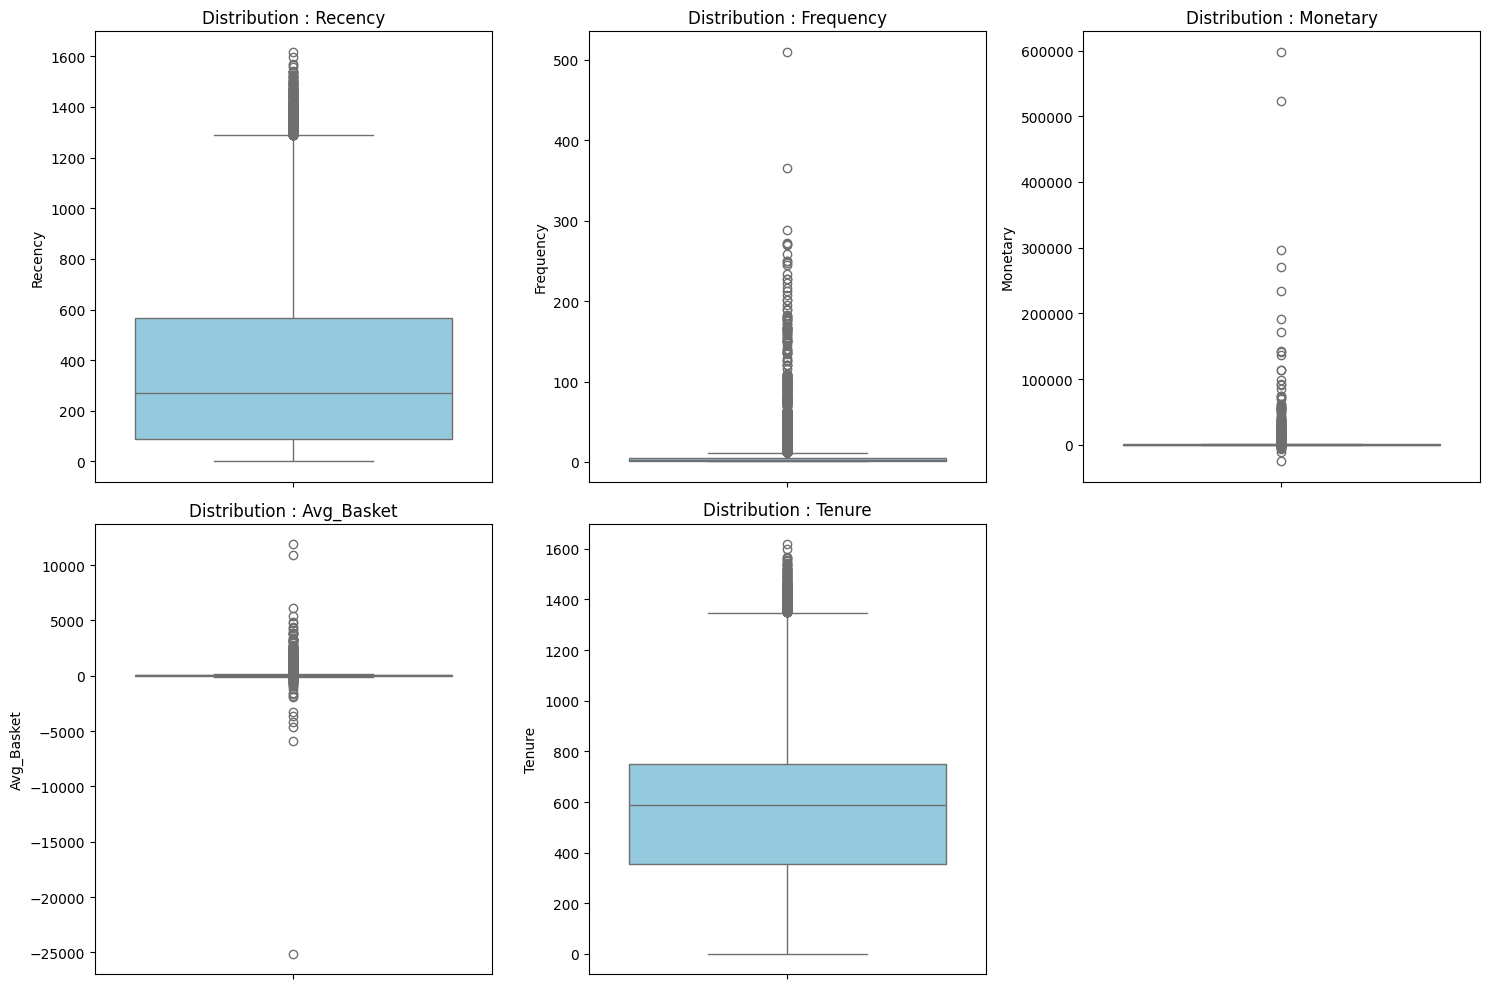

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# ÉTAPE 3 : Visualisation des Outliers
features = ['Recency', 'Frequency', 'Monetary', 'Avg_Basket', 'Tenure']

plt.figure(figsize=(15, 10))

for i, col in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=rfm[col], color='skyblue')
    plt.title(f'Distribution : {col}')

plt.tight_layout()
plt.show()

On observe des valeurs aberrantes, ce qui peut se traduire à quelques clients qui dépensent énormement + que la moyenne.

Le soucis est que si on laisse les données tel quel à l'ia, nos algorithme risque d'etre corrompus et essayer de plaire à ces quelques client et ignorer les 49 9997 autres.

la plupart des gens achètent peu et quelques rares personnes achètent énormément.

### Etape 2 - Hajar


### Scoring RFM

In [68]:
# ÉTAPE 2.1 : Attribution des scores de 1 à 5
# On utilise le rang pour la fréquence car beaucoup de clients n'ont qu'un seul achat

# Récence : Plus c'est petit, mieux c'est (labels inversés)
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

# Fréquence : Plus c'est grand, mieux c'est
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])

# Montant : Plus c'est grand, mieux c'est
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# On concatène les notes pour avoir le score global (ex: 555)
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

print("✅ Scoring terminé ! Voici un aperçu :")
display(rfm[['RFM_Score', 'R', 'F', 'M']].head())

✅ Scoring terminé ! Voici un aperçu :


,RFM_Score,R,F,M
customer_id,,,,
12346.0,351,3,5,1
12347.0,555,5,5,5
12348.0,445,4,4,5
12349.0,545,5,4,5
12350.0,314,3,1,4


### Analyse des segments

In [69]:
# ÉTAPE 2.2 : Calcul des KPIs par segment

total_ca = rfm['Monetary'].sum()

# 1. Les Champions (Score 555)
champions = rfm[rfm['RFM_Score'] == '555']
ca_champions = champions['Monetary'].sum()

# 2. Les Clients à Risque (Anciens mais gros acheteurs : R=1 ou 2, F/M=4 ou 5)
# On simplifie : R inférieur ou égal à 2 ET (F ou M) supérieur ou égal à 4
a_risque = rfm[(rfm['R'].astype(int) <= 2) & (rfm['F'].astype(int) >= 4)]

# 3. Les Perdus (Score 111)
perdus = rfm[rfm['RFM_Score'] == '111']

print(f"🏆 Champions (555) : {len(champions)} clients")
print(f"💰 Part du CA des Champions : {(ca_champions / total_ca):.2%}")
print(f"⚠️ Clients À Risque : {len(a_risque)} clients")
print(f"❄️ Clients Perdus (111) : {len(perdus)} clients (soit {len(perdus)/len(rfm):.2%})")

🏆 Champions (555) : 3585 clients
💰 Part du CA des Champions : 56.70%
⚠️ Clients À Risque : 3163 clients
❄️ Clients Perdus (111) : 2681 clients (soit 5.46%)


555 : ils ne sont que 2664 environ 5% sur les 50 000 clients.

impact : ils génèrent 52.86% du CA total.
le business repose sur une élite de clients très fidèles, si on perds ces 2600 clients, on risque de perdre la moitié du CA.

action : on ne leur envoie pas de promo prix bas, on leur offre de l'exclusivité, des avant premieres, on les consideres comme des membres VIP..

Les clients a risque sont d'un volume de 2 613 clients, ce sont les clients qui étaient des 555(gros montants historiques) mais qui n'ont rien acheté depuis longtemps.

Dans l'urgence, ils sont au bord du désengagement total, il faut les relancer et les reactiver immédiatement.

### Matrice RFM

/tmp/ipython-input-479/3946353820.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matrix = rfm.pivot_table(index='R', columns='F', values='Monetary', aggfunc='mean')


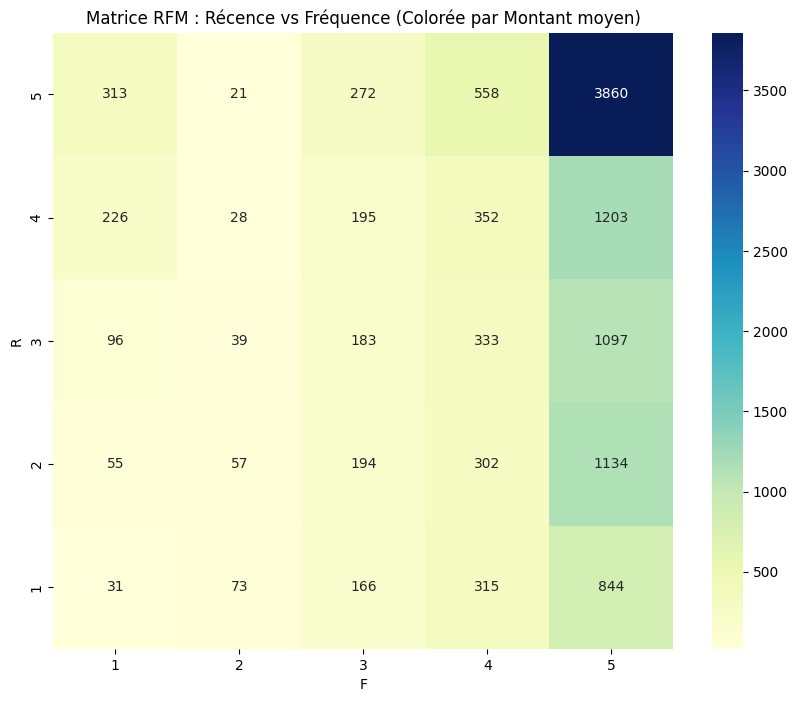

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# On crée un tableau croisé : Récence vs Fréquence avec la moyenne du Montant
matrix = rfm.pivot_table(index='R', columns='F', values='Monetary', aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Matrice RFM : Récence vs Fréquence (Colorée par Montant moyen)")
plt.show()

Le coin en haut à droite (R=5, F=5) est "bleu foncé" avec une moyenne de 1 140€

On voit clairement que plus la fréquence augmente (vers la droite), plus le panier moyen explose. La fidélité ici n'est pas juste une habitude, c'est une augmentation de la valeur.



Reco : Concentrer 80% du budget marketing sur les 5% de Champions et les Clients à Risque. Le coût d'acquisition d'un nouveau client serait ici moins rentable que de chouchouter l'existant.

Investigation: Pourquoi 22% de transactions sans ID ? Si on arrive à identifier ne serait-ce que 10% de ces clients, on augmente mécaniquement la précision de notre ciblage.



###Transformation logarithmique

In [71]:
import numpy as np

# ÉTAPE 1 : Transformation Log pour "calmer" les outliers
# On crée un nouveau DataFrame pour ne pas écraser l'original
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].copy()

rfm_log['Recency'] = np.log1p(rfm_log['Recency'])
rfm_log['Frequency'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary'] = np.log1p(rfm_log['Monetary'])

print("✅ Transformation Logarithmique terminée.")

✅ Transformation Logarithmique terminée.


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


###Standardisation

In [72]:
from sklearn.preprocessing import StandardScaler

# ÉTAPE 2 : Mise à l'échelle (Standardisation)
# On ramène chaque variable à une moyenne de 0 et un écart-type de 1
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# On repasse en DataFrame pour pouvoir l'analyser facilement
rfm_scaled_df = pd.DataFrame(rfm_scaled, index=rfm.index, columns=['Recency', 'Frequency', 'Monetary'])

print("✅ Standardisation terminée. Les données sont prêtes pour l'IA.")

✅ Standardisation terminée. Les données sont prêtes pour l'IA.


###Control avant/après

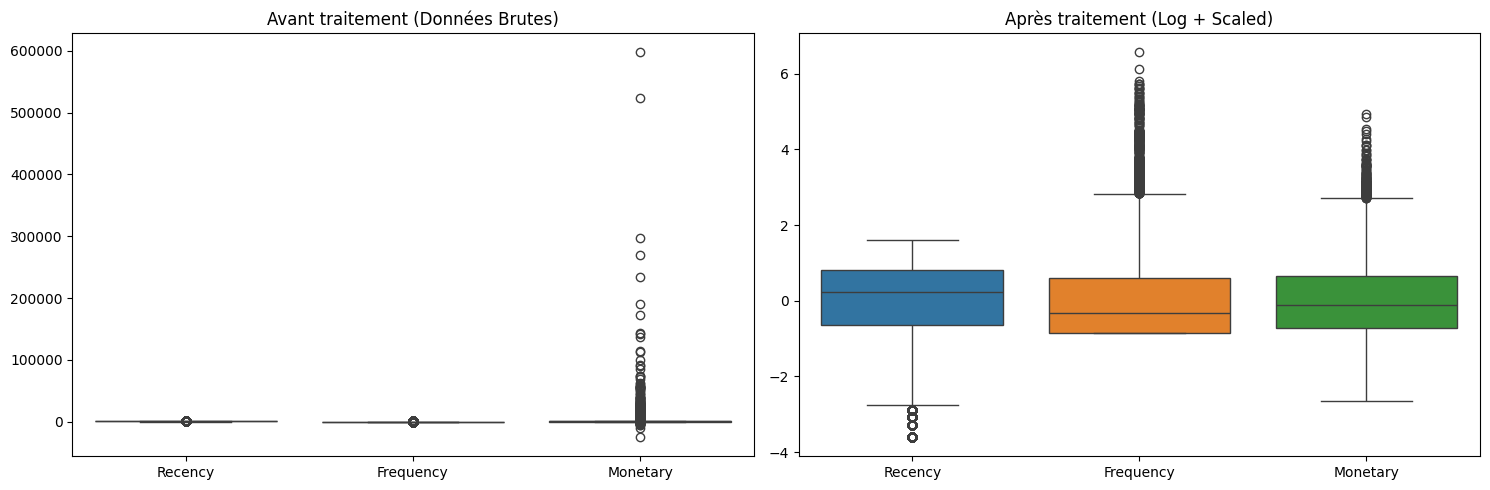

In [73]:
# ÉTAPE 3 : Vérification avec des Boxplots
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=rfm[['Recency', 'Frequency', 'Monetary']])
plt.title("Avant traitement (Données Brutes)")

plt.subplot(1, 2, 2)
sns.boxplot(data=rfm_scaled_df)
plt.title("Après traitement (Log + Scaled)")

plt.tight_layout()
plt.show()

In [74]:
# 1. On sauvegarde le DataFrame scalé (prêt pour l'IA) en fichier CSV
rfm_scaled_df.to_csv('rfm_for_clustering.csv')

from google.colab import files
files.download('rfm_for_clustering.csv')

print("Fichier 'rfm_for_clustering.csv' prêt pour l'Étape 3 !")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fichier 'rfm_for_clustering.csv' prêt pour l'Étape 3 !


###Etape 3 - Meryem